In [2]:
import pandas as pd
import random
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Load data

naca4digits = pd.read_csv('../input/naca5digits-precprocessed/NACA5digits_preprocessed_new.csv')
naca4digits = naca4digits.drop('Unnamed: 0', axis = 1)
naca4digits = naca4digits.astype('float64')
naca4digits = naca4digits.dropna()
naca4digits

,AOA,Cl Thwaites,Cd Thwaites,des_cl,max_pos,thick
0,-8.0,-0.740295,0.042106,2.0,10.0,1.0
1,-7.9,-0.731057,0.041584,2.0,10.0,1.0
2,-7.8,-0.721806,0.041060,2.0,10.0,1.0
3,-7.7,-0.712541,0.040541,2.0,10.0,1.0
4,-7.6,-0.703262,0.040023,2.0,10.0,1.0
...,...,...,...,...,...,...
24145,7.6,1.244325,0.006511,2.0,50.0,30.0
24146,7.7,1.257531,0.006431,2.0,50.0,30.0
24147,7.8,1.270737,0.006438,2.0,50.0,30.0
24148,7.9,1.283939,0.006446,2.0,50.0,30.0


In [46]:
# Generate data and target datasets

data   = pd.DataFrame(naca4digits, columns = ['AOA', 'Cl Thwaites', 'Cd Thwaites'])
target = pd.DataFrame(naca4digits, columns = ['max_cam', 'max_pos', 'thick'])
print('Data shape', data.shape)
print('Target shape', target.shape)
data.describe()

Data shape (24150, 3)
Target shape (24150, 3)


,AOA,Cl Thwaites,Cd Thwaites
count,2.415000e+04,24150.000000,24150.000000
mean,-1.162171e-14,0.137769,0.006255
std,4.647676e+00,0.571501,0.003781
min,-8.000000e+00,-0.975260,0.002342
25%,-4.000000e+00,-0.355180,0.005089
50%,-1.168510e-14,0.136399,0.005874
75%,4.000000e+00,0.628054,0.006419
max,8.000000e+00,1.297138,0.090982


In [5]:
target.describe()

,max_cam,max_pos,thick
count,466298.000000,466298.000000,466298.000000
mean,4.390480,4.551471,15.350353
std,2.852523,2.833761,8.635542
min,0.000000,0.000000,1.000000
25%,2.000000,2.000000,8.000000
50%,4.000000,5.000000,15.000000
75%,7.000000,7.000000,23.000000
max,9.000000,9.000000,30.000000


In [6]:
# Split in train and test

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = seed, shuffle = True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(373038, 3) (373038, 3)
(93260, 3) (93260, 3)


In [7]:
# Normalize both features and target

max_df = X_train.max()
min_df = X_train.min()
max_t = y_train.max()
min_t = y_train.min()

X_train = (X_train - min_df)/(max_df - min_df)
y_train = (y_train - min_t)/(max_t - min_t)

target.describe()

,max_cam,max_pos,thick
count,466298.000000,466298.000000,466298.000000
mean,4.390480,4.551471,15.350353
std,2.852523,2.833761,8.635542
min,0.000000,0.000000,1.000000
25%,2.000000,2.000000,8.000000
50%,4.000000,5.000000,15.000000
75%,7.000000,7.000000,23.000000
max,9.000000,9.000000,30.000000


In [8]:
# Normalize the test set with the same parameters of training set
X_test = (X_test - min_df)/(max_df - min_df)
y_test = (y_test - min_t)/(max_t - min_t)

In [9]:
X_train.describe()

,AOA,Cl Thwaites,Cd Thwaites
count,373038.000000,373038.000000,373038.000000
mean,0.501186,0.385068,0.564481
std,0.289857,0.169358,0.036378
min,0.000000,0.000000,0.000000
25%,0.250000,0.259948,0.559523
50%,0.500000,0.380465,0.567185
75%,0.750000,0.498469,0.573184
max,1.000000,1.000000,1.000000


In [10]:
input_shape = X_train.shape[1:]

In [11]:
def build_ffnn(input_shape):

    # Build the neural network layer by layer
    input_layer   = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=1024, activation='relu', name='Hidden1')(input_layer)
    dropout1      = tfkl.Dropout(0.1, name = 'Dropout1')(hidden_layer1)
    hidden_layer2 = tfkl.Dense(units=512, activation='relu', name='Hidden2')(dropout1)
    dropout2      = tfkl.Dropout(0.1, name = 'Dropout2')(hidden_layer2)
    hidden_layer3 = tfkl.Dense(units=256, activation='relu', name='Hidden3')(dropout2)
    dropout3      = tfkl.Dropout(0.1, name = 'Dropout3')(hidden_layer3)
    hidden_layer4 = tfkl.Dense(units=128, activation='relu', name='Hidden4')(dropout3)
    output_layer1  = tfkl.Dense(units=3, activation = tfk.activations.exponential, name='Output1')(hidden_layer4)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs = output_layer1, name='Airfoil_Analysis_Neural_Network')

    # Compile the model
    loss = 'mse'
    learning_rate = 3e-4
    optimizer = tfk.optimizers.Adam(learning_rate)
    model.compile(loss=loss, optimizer=optimizer)

    # Return the model
    return model

2022-11-07 09:16:57.399799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:16:57.501736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:16:57.502540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:16:57.503652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "Airfoil_Analysis_Neural_Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 3)]               0         
_________________________________________________________________
Hidden1 (Dense)              (None, 1024)              4096      
_________________________________________________________________
Dropout1 (Dropout)           (None, 1024)              0         
_________________________________________________________________
Hidden2 (Dense)              (None, 512)               524800    
_________________________________________________________________
Dropout2 (Dropout)           (None, 512)               0         
_________________________________________________________________
Hidden3 (Dense)              (None, 256)               131328    
_________________________________________________________________
Dropout3 (Dropout)           (None,

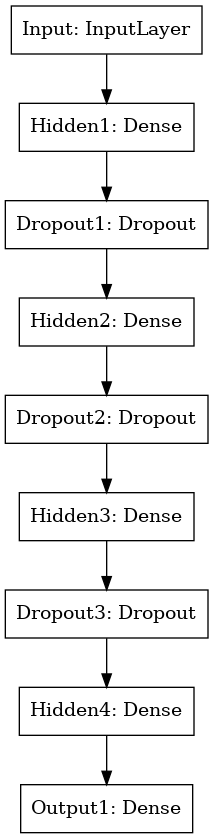

In [12]:
ffnn = build_ffnn(input_shape)
ffnn.summary()
tfk.utils.plot_model(ffnn)

In [13]:
# Train the model

from time import time

start = time()

batch_size = 256
epochs = 300

reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=6e-5, verbose = 1)
early_stop = tfk.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True, verbose = 1)

history = ffnn.fit(
    x = X_train,
    y = y_train, 
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
    callbacks = [reduce_lr, early_stop]
).history

ffnn.save("first_attempt.h5", include_optimizer=False)

converter = tf.lite.TFLiteConverter.from_keras_model(ffnn)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
print(interpreter.get_signature_list())
print(time()-start)

2022-11-07 09:17:01.266869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
1166/1166 [==============================] - 5s 3ms/step - loss: 0.0575 - val_loss: 0.0401
Epoch 2/300
1166/1166 [==============================] - 3s 3ms/step - loss: 0.0410 - val_loss: 0.0363
Epoch 3/300
1166/1166 [==============================] - 3s 3ms/step - loss: 0.0381 - val_loss: 0.0355
Epoch 4/300
1166/1166 [==============================] - 3s 2ms/step - loss: 0.0369 - val_loss: 0.0350
Epoch 5/300
1166/1166 [==============================] - 3s 3ms/step - loss: 0.0364 - val_loss: 0.0355
Epoch 6/300
1166/1166 [==============================] - 3s 3ms/step - loss: 0.0359 - val_loss: 0.0366
Epoch 7/300
1166/1166 [==============================] - 3s 2ms/step - loss: 0.0356 - val_loss: 0.0349
Epoch 8/300
1166/1166 [==============================] - 3s 2ms/step - loss: 0.0353 - val_loss: 0.0339
Epoch 9/300
1166/1166 [==============================] - 3s 3ms/step - loss: 0.0350 - val_loss: 0.0338
Epoch 10/300
1166/1166 [==============================] - 3s 3ms/step - l

2022-11-07 09:31:59.609785: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-07 09:32:00.389403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:32:00.389765: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-11-07 09:32:00.389884: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-11-07 09:32:00.390339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:32:00.390710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

{}
899.4889416694641


In [14]:
print(interpreter.get_signature_list())

{}


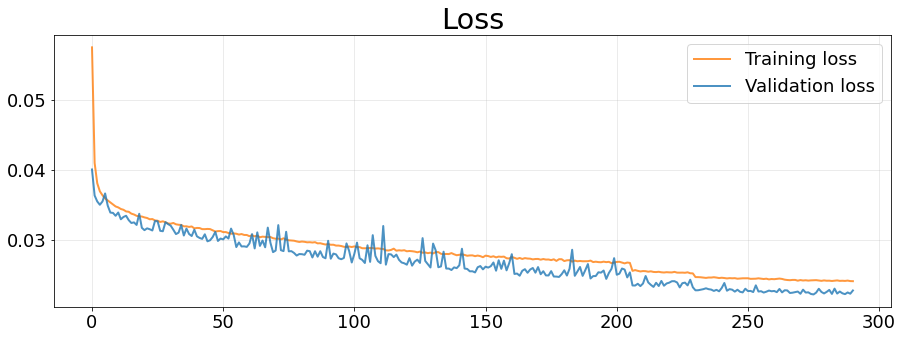

In [15]:
from matplotlib import rcParams
from matplotlib import ticker

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 24
rcParams['figure.figsize'] = (20, 10)

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e', linewidth = 2)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8, linewidth = 2)
plt.title('Loss')
plt.legend(fontsize = 18)
plt.grid(alpha=.3)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, ffnn.predict(X_test))

0.022023510797124224

In [17]:
min_t

max_cam    0.0
max_pos    0.0
thick      1.0
dtype: float64

In [18]:
X_train.min()

min_input  = np.array([min_df['AOA'], min_df['Cl Thwaites'], min_df['Cd Thwaites']])
max_input  = np.array([max_df['AOA'], max_df['Cl Thwaites'], max_df['Cd Thwaites']]) 

min_output  = np.array([min_t['max_cam'], min_t['max_pos'], min_t['thick']])
max_output  = np.array([max_t['max_cam'], max_t['max_pos'], max_t['thick']])
print(min_input)
print(max_input)
print(min_output)
print(max_output)

[-8.         -1.06830704 -0.09636456]
[8.         3.4748194  0.08257051]
[0. 0. 1.]
[ 9.  9. 30.]


In [19]:
def normalize_input(x):
    x = (x - min_input) / (max_input - min_input)
    return x

def denormalize_output(x):
    x = x * (max_output - min_output) + min_output
    return x

In [20]:
my_check = np.array([4.0, 0.69159, 0.00546])
my_check = normalize_input(my_check)
my_check = my_check.reshape((1,-1))
my_check

array([[0.75      , 0.38737576, 0.56905873]])

In [21]:
result = ffnn.predict(my_check)
result = denormalize_output(result)
print(np.round(result))

[[ 1.  7. 18.]]


In [22]:
!zip -r './out.zip' './'

  adding: __notebook_source__.ipynb (deflated 44%)
  adding: .virtual_documents/ (stored 0%)
  adding: model.png (deflated 20%)
  adding: first_attempt.h5 (deflated 8%)


In [23]:
!pip install toco

!toco --output_file=trained_model.tflite --keras_model_file=first_attempt.h5

2022-11-07 09:32:18.266178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:32:18.275260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:32:18.275693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 09:32:18.310477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil